## Chest X-Ray Images using CNN Model

### About Dataset

* The dataset consists of training data, validation data, and testing data.
* The training data consists of 5,216 chest x-ray images with 3,875 images shown to have pneumonia and 1,341 images shown to be normal.
* The validation data is relatively small with only 16 images with 8 cases of pneumonia and 8 normal cases.
* The testing data consists of 624 images split between 390 pneumonia cases and 234 normal cases.

### What is Pneumonia?

Pneumonia is an infection in one or both lungs. Bacteria, viruses, and fungi cause it. The infection causes inflammation in the air sacs in your lungs, which are called alveoli. The alveoli fill with fluid or pus, making it difficult to breathe.

![](https://d16qt3wv6xm098.cloudfront.net/I7a1xCoDRliAGg8FBvnVZFTITK2Ao3wY/_.jpg)

### Import libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Input, layers
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.core import Activation, Dropout, Flatten, Dense
from keras import backend as K
from keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


import os
import numpy as np
import pandas as np
import seaborn as sns

from random import randint
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
!pip install kaggle

In [3]:
! mkdir ~/.kaggle

In [5]:
! cp kaggle.json ~/.kaggle/

In [6]:
! kaggle datasets download paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:26<00:00, 28.0MB/s]
100% 2.29G/2.29G [00:26<00:00, 93.4MB/s]


In [8]:
import os
import zipfile
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
local_zip = '/content/chest-xray-pneumonia.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

### Load the data

In [19]:
main_dir = "/tmp/chest_xray/chest_xray/"
train_data_dir = main_dir + "train/"
validation_data_dir = main_dir + "val/"
test_data_dir = main_dir + "test/"

nb_train_samples = 5216
nb_validation_samples = 16
epochs = 30
batch_size = 64

print("Working Directory Contents:", os.listdir(main_dir))

Working Directory Contents: ['train', '.DS_Store', 'test', 'val']


In [20]:
train_n = train_data_dir+'NORMAL/'
train_p = train_data_dir+'PNEUMONIA/'

print("length of cases in training set:",len(os.listdir(train_p)) + len(os.listdir(train_n)))
print("length of pneumonia cases in training set:",len(os.listdir(train_p)))
print("length of normal cases in training set:",len(os.listdir(train_n)))

length of cases in training set: 5218
length of pneumonia cases in training set: 3876
length of normal cases in training set: 1342


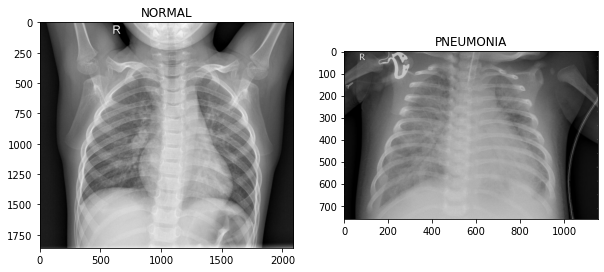

In [21]:
# Quick look to the images 

img_name = 'IM-0115-0001.jpeg'
img_normal = load_img('/tmp/chest_xray/train/NORMAL/' + img_name)

img_name_1 = 'person1000_bacteria_2931.jpeg'
img_pneumonia = load_img('/tmp/chest_xray/train/PNEUMONIA/' + img_name_1)

fig, axs = plt.subplots(1,2,figsize=(10,6))
axs[0].imshow(img_normal)
axs[0].set_title("NORMAL")
axs[1].imshow(img_pneumonia)
axs[1].set_title("PNEUMONIA");

The actual sizes of the photos are so high that I set them to size 180x180.

In [22]:
img_height, img_width  = 180, 180


if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

### Upload images

In [23]:
# Performing Image Augmentation to have more data samples

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)
val_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = val_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


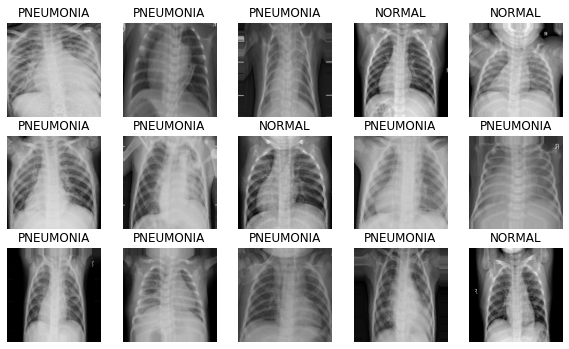

In [24]:
# Show some images after data augmentation

image_batch, label_batch = next(iter(train_generator))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for n in range(15):
        ax = plt.subplot(5, 5, n + 1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

show_batch(image_batch, label_batch)

Model 1

### Build the CNN

In [25]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3),  activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 22, 22, 64)       0

### Train the model

### Callbacks

* EarlyStopping (Stop training when a monitored metric has stopped improving)

* ReduceLROnPlateau (Reduce learning rate when a metric has stopped improving)

* ModelCheckpoint (Callback to save the Keras model or model weights at some frequency)

In [26]:
# Define the callbacks

callbacks1 = [ 
    EarlyStopping(monitor = 'loss', patience = 6), 
    ReduceLROnPlateau(monitor = 'loss', patience = 3), 
    ModelCheckpoint('../working/model.best3.hdf5',monitor='loss', save_best_only=True) # saving the best model
]

### Correct for the imbalance

Data is imbalanced, with more images classified as pneumonia than normal. We will correct for that by using class weighting

In [27]:
count_normal = len(train_n)
count_pneumonia = len(train_p)

initial_bias = count_pneumonia / count_normal
print("Initial bias: {:.5f}".format(initial_bias))

TRAIN_IMG_COUNT = count_normal + count_pneumonia
weight_for_0 = (1 / count_normal) * (TRAIN_IMG_COUNT) / 2.0
weight_for_1 = (1 / count_pneumonia) * (TRAIN_IMG_COUNT) / 2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print("Weight for class 0: {:.2f}".format(weight_for_0))
print("Weight for class 1: {:.2f}".format(weight_for_1))

Initial bias: 1.07500
Weight for class 0: 1.04
Weight for class 1: 0.97


In [28]:
METRICS = [tf.keras.metrics.BinaryAccuracy(),
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall")]

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=METRICS)

### Fit the model

In [29]:
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=callbacks1)
    #class_weight=class_weight)

Epoch 1/30
82/82 [==============================] - 123s 1s/step - loss: 0.5055 - binary_accuracy: 0.7797 - precision: 0.8164 - recall: 0.9076 - val_loss: 0.3765 - val_binary_accuracy: 0.7500 - val_precision: 0.7500 - val_recall: 0.7500 - lr: 0.0010
Epoch 2/30
82/82 [==============================] - 90s 1s/step - loss: 0.3174 - binary_accuracy: 0.8715 - precision: 0.9027 - recall: 0.9270 - val_loss: 1.1479 - val_binary_accuracy: 0.6250 - val_precision: 0.5714 - val_recall: 1.0000 - lr: 0.0010
Epoch 3/30
82/82 [==============================] - 91s 1s/step - loss: 0.2707 - binary_accuracy: 0.8903 - precision: 0.9249 - recall: 0.9277 - val_loss: 0.3420 - val_binary_accuracy: 0.8125 - val_precision: 0.7273 - val_recall: 1.0000 - lr: 0.0010
Epoch 4/30
82/82 [==============================] - 92s 1s/step - loss: 0.2379 - binary_accuracy: 0.9062 - precision: 0.9343 - recall: 0.9399 - val_loss: 0.3883 - val_binary_accuracy: 0.8750 - val_precision: 0.8000 - val_recall: 1.0000 - lr: 0.0010
Epo

### Predict and evaluate results

In [30]:
# Evaluate the model
scores = model.evaluate(test_generator, return_dict=True)

print(scores)
#print("Loss of the model: %.2f"%(scores[0]))
#print("Test Accuracy: %.2f%%"%(scores[1] * 100))

10/10 [==============================] - 6s 645ms/step - loss: 0.6499 - binary_accuracy: 0.8846 - precision: 0.8518 - recall: 0.9872
{'loss': 0.6498610377311707, 'binary_accuracy': 0.8846153616905212, 'precision': 0.8517699241638184, 'recall': 0.9871794581413269}


In [34]:
# Saving the model for future use

from keras.models import load_model

model.save('/tmp/chestxray_cnn_model_3.h5')